In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics


In [2]:
df=pd.read_csv('/Users/namchangseok/Desktop/코드스테이츠/AI_12기/cp2/split_data.csv')

In [3]:
# 데이터 전처리 
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets['main_category'] =df_targets['category_code'].str.split('.',expand=True)[0].astype('category')
df_targets['middle_category'] =df_targets['category_code'].str.split('.',expand=True)[1].astype('category')

In [4]:
df_targets.dropna(how='any', inplace=True)

In [7]:
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])

In [8]:
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

In [9]:
# session 활동 개수 합치기 
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [9]:
activity_in_session

,user_session,activity_count
0,00000083-8816-4d58-a9b8-f52f54186edc,18
1,000001fd-1f89-45e8-a3ce-fe3218cabfad,11
2,000003eb-b63e-45d9-9f26-f229057c654a,1
3,00000809-9101-4e4b-9795-e6cbafccfe19,4
4,00000aaa-d774-49bc-9c31-0c9f6e1c2f0a,1
...,...,...
2331286,ffffd6fe-a5c3-4c9e-bc57-8d7601521cc0,2
2331287,ffffd89d-208c-28ec-da2f-6668c878fffc,1
2331288,ffffdf58-84cb-4337-a802-061db4843e54,1
2331289,ffffe3ba-7c09-4c3a-a8fe-75ba46b1e146,2


In [10]:
df_targets['event_type'].value_counts()

cart    546599
Name: event_type, dtype: int64

In [12]:
del df

In [11]:
df_targets=df_targets.merge(activity_in_session, on='user_session',how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,main_category,middle_category,activity_count
0,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1.0,1,electronics,smartphone,4.0


In [11]:
df_targets.to_csv('training_data.csv')

In [2]:
# Df_targets으로 불러오자
df_targets=pd.read_csv('/Users/namchangseok/Desktop/코드스테이츠/AI_12기/cp2/training_data.csv')

In [3]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]


273908

In [4]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

272691

In [9]:
#샘플링
n_sample = 270000

purchase_down=resample(is_purcahase_set,replace=False,n_samples=n_sample,random_state=42)

not_purchase_down=resample(not_purcahase_set,replace=False,n_samples=n_sample,random_state=42)


In [10]:
sample_data= pd.concat([purchase_down,not_purchase_down])
sample_data.head(1)

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,main_category,middle_category,activity_count
60708,60708,2019-10-05 04:52:52 UTC,cart,1005104,2053013555631882655,electronics.smartphone,apple,975.57,548318522,7298baed-ffb0-4ecb-849d-b1b826189136,1.0,5,electronics,smartphone,18.0


In [11]:
sample_data['is_purchased'].value_counts()

1.0    270000
0.0    270000
Name: is_purchased, dtype: int64

In [15]:
features=sample_data.loc[:,['brand', 'price', 'event_weekday', 'main_category', 'middle_category', 'activity_count']]

In [13]:
sample_data.head(2)

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,main_category,middle_category,activity_count
60708,60708,2019-10-05 04:52:52 UTC,cart,1005104,2053013555631882655,electronics.smartphone,apple,975.57,548318522,7298baed-ffb0-4ecb-849d-b1b826189136,1.0,5,electronics,smartphone,18.0
371462,371462,2019-10-21 14:57:50 UTC,cart,1005208,2053013555631882655,electronics.smartphone,apple,424.70,562656020,24fcd539-5c28-48cd-a930-ebf60bb2df7b,1.0,0,electronics,smartphone,6.0


In [16]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(sample_data.loc[:,'brand'].copy())
#features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(sample_data[:,'event_weekday'].copy())


In [26]:
features.loc[:,'main_category'] = LabelEncoder().fit_transform(sample_data.loc[:,'main_category'].copy())
features.loc[:,'middle_category'] = LabelEncoder().fit_transform(sample_data.loc[:,'middle_category'].copy())

is_purchased = LabelEncoder().fit_transform(sample_data['is_purchased'])
features.head()

,brand,price,event_weekday,main_category,middle_category,activity_count
60708,20,975.57,5,7,27,18.0
371462,20,424.70,0,7,27,6.0
408237,308,24.26,2,7,1,3.0
444561,357,86.86,4,7,27,6.0
121065,158,272.08,2,7,27,42.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [28]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [29]:
print("정확도:",metrics.accuracy_score(y_test, y_pred))
print("정밀도:",metrics.precision_score(y_test, y_pred))
print("재현율:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

정확도: 0.6105802469135803
정밀도: 0.5933636082155022
재현율: 0.708209120697726
fbeta: 0.6100880173787671


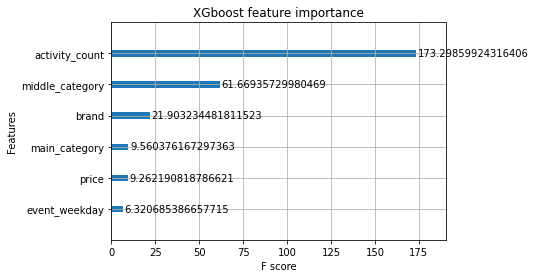

In [36]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.title('XGboost feature importance')
plt.show()

In [18]:
#랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(features,is_purchased,test_size=0.3)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

378000
162000
378000
162000


In [19]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

RandomForestClassifier()

In [23]:

# 정확도 확인
print("정확도:",metrics.accuracy_score(y_test, y_pred))
print("정밀도:",metrics.precision_score(y_test, y_pred))
print("재현율:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

정확도: 0.579358024691358
정밀도: 0.573757028959885
재현율: 0.6204348952230596
fbeta: 0.5791373079751218


<AxesSubplot:title={'center':'Randomforest features importance'}>

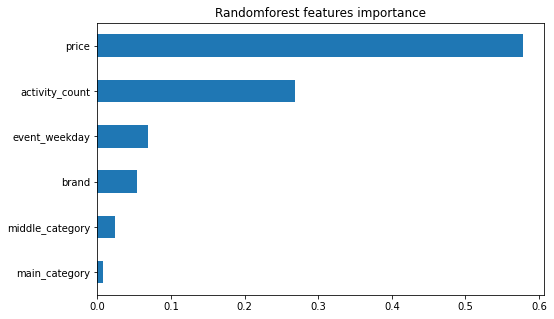

In [42]:
#랜덤 포레스트 특성 중요도
importances = pd.Series(forest.feature_importances_, x_train.columns)
n=7
plt.rcParams['figure.figsize'] = (8,5)
plt.title(f'Randomforest features importance')
importances.sort_values().plot.barh()